In [1]:
import matplotlib.pyplot as plt
import torch
import botorch
import gpytorch

In [2]:
bounds = torch.tensor([-10, 10.])
fn = lambda x: (10. * torch.sin(x)+1) * (torch.sin(3. * x) / x).nan_to_num(1.) #+ torch.cos(3. * x)
noise = lambda x: 2.0 * torch.sigmoid(0.5 * x)

In [3]:
xx = torch.linspace(-10., 10., 1000)

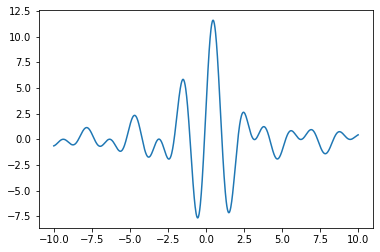

In [4]:
plt.plot(xx, fn(xx))

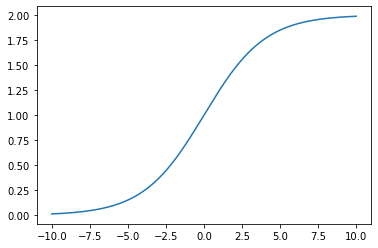

In [5]:
plt.plot(xx, noise(xx))

In [6]:
from botorch.models import HeteroskedasticSingleTaskGP
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.acquisition.monte_carlo import qUpperConfidenceBound, qExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

In [7]:
from botorch.acquisition.penalized import PenalizedAcquisitionFunction
from botorch.optim.optimize import optimize_acqf

In [8]:
class LCBPenalty(torch.nn.Module):
    def __init__(self, noise_model, alpha = 0.2):
        super().__init__()
        self.noise_model = noise_model
        self.alpha = 0.2
    
    def forward(self, x):
        # need to do the batch ucb version for q > 1
        nm_post = self.noise_model.posterior(x)
        return -1. * (nm_post.mean - self.alpha * nm_post.variance.pow(0.5)).sum(-2).sum(-1)

In [9]:
class HetEIPenalty(torch.nn.Module):
    def __init__(self, acqf, model, gamma = 0.2):
        super().__init__()
        self.acqf = acqf
        self.model = model
        self.gamma = gamma
        
    def forward(self, x):
        acqf_x = self.acqf(x)
        
        pred_var_w_obs_noise = self.model.posterior(x, observation_noise=True).variance
        pred_var_wo_obs_noise = self.model.posterior(x, observation_noise=False).variance
        scaling = self.gamma * pred_var_wo_obs_noise.sqrt() / \
            (pred_var_w_obs_noise + (self.gamma ** 2) * pred_var_wo_obs_noise).sqrt()
        # again q = 1 only
        return -scaling.sum(-1).sum(-2) * acqf_x

In [10]:
def generate_data_for_gp(inp=None, k = 3, n = 15):
    if inp is None:
        inp = torch.rand(n, 1) * (bounds[1] - bounds[0]) + bounds[0]
        inp = inp[inp.abs() > 3]
        inp = inp.view(-1,1)
    full_y = torch.stack([fn(inp) + noise(inp).sqrt() * torch.randn_like(inp) for _ in range(k)])
    return inp, full_y.mean(0), full_y.std(0)

In [11]:
def run_experiment(n_steps=20, n_init=10, k = 3, acqf="hetei"):
    x, y, y_std = generate_data_for_gp(k=k, n=n_init)
    # for step in range(n_steps):
    step = 0
    while x.shape[0] < (n_steps + n_init):
        
        if step % 5 == 0:
            print(step, y.max())
    
        # do penalized EI and acquire candidates
        model = HeteroskedasticSingleTaskGP(x, y, y_std.pow(2.) / k)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        try:
            with gpytorch.settings.cholesky_max_tries(10):
                fit_gpytorch_scipy(mll);
        except:
            model = HeteroskedasticSingleTaskGP(x, y, y_std.pow(2.) / k)
            print("Warning gp fitting failed")
        model.requires_grad_(False)

        if acqf == "hetei":
            raw_acqf = qExpectedImprovement(model=model, best_f=y.max())
            penalty = HetEIPenalty(raw_acqf, model)
        elif acqf == "hetucb":
            raw_acqf = qUpperConfidenceBound(model=model,beta=0.1)
            penalty = LCBPenalty(model.likelihood.noise_covar.noise_model)

        acqf = PenalizedAcquisitionFunction(raw_acqf, penalty, regularization_parameter=0.1)

        candidates, _ = optimize_acqf(
            acq_function=acqf,
            bounds=bounds.view(2,1),
            q=1,
            num_restarts = 5,
            raw_samples=256,
        )
        next_x = candidates.view(-1,1)
        _, next_y, next_y_std = generate_data_for_gp(next_x, k=k)
        x = torch.cat((x, next_x))
        y = torch.cat((y, next_y))
        y_std = torch.cat((y_std, next_y_std))

        del model
        
        step += 1
        
    return x, y, y_std

In [ ]:
hetei_trials = [run_experiment(acqf="hetei") for _ in range(16)]

0 tensor(1.3783)
5 tensor(1.3783)
10 tensor(1.3783)
15 tensor(1.3783)
20 tensor(1.3783)
0 tensor(0.1271)
5 tensor(1.7523)
10 tensor(1.7523)
15 tensor(1.8298)
20 tensor(1.8298)
0 tensor(1.9126)
5 tensor(2.7113)
10 tensor(2.7113)
15 tensor(2.7113)
20 tensor(2.7113)
0 tensor(2.0412)
5 tensor(2.0412)
10 tensor(2.0412)
15 tensor(2.0412)
20 tensor(2.0412)
0 tensor(1.3578)


In [ ]:
hetucb_trials = [run_experiment(acqf="hetucb") for _ in range(16)]

In [ ]:
hetucb_y = [x[1] for x in hetucb_trials]
hetei_y = [x[1] for x in hetei_trials]

In [ ]:
plt.plot(torch.stack([x[:24] for x in hetucb_y]).cummax(1)[0].squeeze().mean(0))
plt.plot(torch.stack([x[:24] for x in hetei_y]).cummax(1)[0].squeeze().mean(0))

In [ ]:
torch.save({"hetucb": hetucb_trials, "hetei": hetei_trials}, "hetacquisitions_highnoise.pt")

In [ ]:
import math

import sys
sys.path.append("..")
from conformalbo.acquisitions import qConformalExpectedImprovement, qConformalUpperConfidenceBound
from botorch.sampling import IIDNormalSampler
from conformalbo.ratio_estimation import RatioEstimator, optimize_acqf_sgld
from botorch.models import SingleTaskGP
from lambo.utils import DataSplit, update_splits

In [ ]:
device = torch.device("cuda:1")

In [ ]:
def run_conformal_experiment(
    n_steps=20, n_init=10, acqf="cucb", 
    mc_samples=64, min_alpha=0.05, temp=0.01,
):
    x, y, _ = generate_data_for_gp(k=1, n=n_init)
    x = x.to(device)
    y = y.to(device)
    # for step in range(n_steps):
    step = 0
    while x.shape[0] < (n_steps + n_init):
        
        if step % 5 == 0:
            print(step, y.max())
    
        model = SingleTaskGP(x, y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        try:
            with gpytorch.settings.cholesky_max_tries(10):
                fit_gpytorch_scipy(mll);
        except:
            print("Warning gp fitting failed")
        model.requires_grad_(False)

        sampler = IIDNormalSampler(num_samples=mc_samples, batch_range=(0, -3))
        
        num_total = x.shape[0]
        
        # prepare density ratio estimator
        rx_estimator = RatioEstimator(x.size(-1), x.device, x.dtype)
        rx_estimator.dataset._update_splits(
            DataSplit(x.cpu(), torch.zeros(x.size(0), 1))
        )     
        
        # set alpha
        alpha = max(1.0 / math.sqrt(num_total), min_alpha)
        conformal_kwargs = {}
        conformal_kwargs['alpha'] = alpha
        conformal_kwargs['temp'] = temp
        conformal_kwargs['max_grid_refinements'] = 0
        conformal_kwargs['ratio_estimator'] = rx_estimator
        conformal_kwargs["grid_res"] = 64
            
        if acqf == "cucb":
            acqf = qConformalUpperConfidenceBound(
                model=model, sampler=sampler, beta=0.2,
                **conformal_kwargs
            )
        elif acqf == "cei":
            acqf = qConformalExpectedImprovement(model=model, best_f=y.max(), 
                                                 sampler=sampler, **conformal_kwargs)

        candidates, _ = optimize_acqf_sgld(
            acq_function=acqf,
            bounds=bounds.view(2,1).to(device),
            q=1,
            num_restarts = 5,
            raw_samples=256,
            sgld_steps=200,
            sgld_temperature=0.05,
            sgld_lr=1e-3,
        )
        next_x = candidates.view(-1,1)
        _, next_y, _ = generate_data_for_gp(next_x, k=1)
        x = torch.cat((x, next_x.to(device)))
        y = torch.cat((y, next_y.to(device)))
        # y_std = torch.cat((y_std, next_y_std))

        del model
        
        step += 1
        
    return x, y, None

In [ ]:
cucb_trials = [run_conformal_experiment(n_steps=60, acqf="cucb") for _ in range(16)]

In [ ]:
cei_trials = [run_conformal_experiment(n_steps=60, acqf="cei") for _ in range(16)]

In [ ]:
!nvidia-smi

In [ ]:
1+1

In [ ]:
!nvidia-smi